In [58]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [30]:
# Example usage:
input_raster_path = 'out_raster/classified/gli_classes_hijo.tif'
output_raster_path = 'out_raster/resample/gli_resample_hijo.tif'
target_resolution = 3  # Set the desired target resolution

with rasterio.open(input_raster_path) as src:
        # Read the raster data
    raster_data = src.read(1)

        # Get the metadata of the input raster
    meta = src.meta.copy()

    # Calculate the new dimensions based on the target resolution
    new_height = int(src.height * src.res[0] / target_resolution)
    new_width = int(src.width * src.res[1] / target_resolution)

        # Perform spatial interpolation using bilinear resampling
    interpolated_data = np.empty((new_height, new_width), dtype=raster_data.dtype)
    rasterio.warp.reproject(
            source=raster_data,
            destination=interpolated_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=src.transform * src.transform.scale(
                (src.width / new_width), (src.height / new_height)
            ),
            dst_crs=src.crs,
            resampling=Resampling.bilinear
    )

        # Update metadata with new dimensions and resolution
    meta.update({
            'width': new_width,
            'height': new_height,
            'transform': src.transform * src.transform.scale(
                (src.width / new_width), (src.height / new_height)
            ),
            'res': (target_resolution, target_resolution)
        })



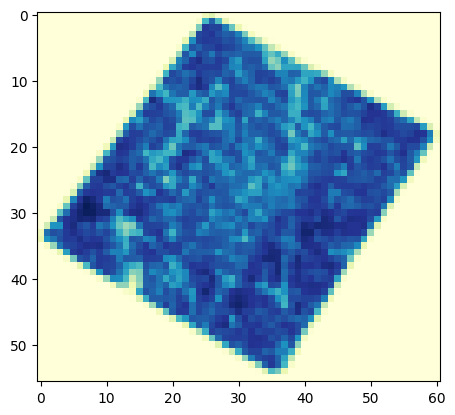

In [31]:
plt.imshow(interpolated_data, cmap='YlGnBu')

In [32]:
# Write the interpolated raster to the output file
with rasterio.open(output_raster_path, 'w', **meta) as dst:
    dst.write(interpolated_data, 1)

#APPLY FILTERS

In [29]:
import rasterio
from rasterio.windows import Window
from rasterio.features import rasterize
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
from skimage import filters
import numpy as np
from skimage.filters import gaussian, median
import cv2

In [75]:
input_raster = 'out_raster/resample/gli_resample.tif'
output_raster = 'out_raster/median/gli_med.tif'

In [76]:
with rasterio.open(input_raster) as src:
    profile = src.profile
    meta = src.meta
    filtered_data = uniform_filter(src.read(1), size=(1,1)) # adjust the size based on ha
    extent = src.bounds

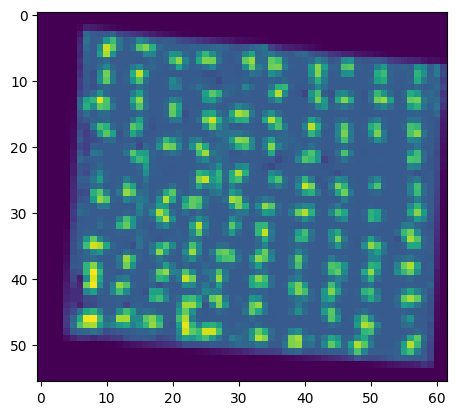

In [77]:
plt.imshow(filtered_data)

In [78]:
# Additional Functions to clean raster data

# Apply smooth edges
def smooth_edges(filtered_data, edge_detection_method='sobel'):
    edges = filters.sobel(filtered_data)
    smooth_edges = filters.gaussian(edges, sigma=0.1)
    return smooth_edges

# # Reduce noise
# def reduce_noise(filtered_data, threshold=5):
#     std = np.std(filtered_data)
#     noise_mask = np.abs(filtered_data - np.mean(filtered_data)) > std * threshold
#     noise_reduced_data = np.where(noise_mask, np.mean(filtered_data), filtered_data)
#     return noise_reduced_data

# def reduce_noise_median(filtered_data):
#     return median(filtered_data)

# def smooth_edge_gaus(filtered_data, sigma=0.01):
#     return gaussian(filtered_data, sigma=sigma)

# def smooth_edges_cv2(filtered_data, sigma_s=1.5, sigma_r=0.5):
#     return cv2.bilateralFilter(filtered_data, -1, sigma_s, sigma_r)

# def average_edge(filtered_data):
#     kernel = np.ones((3,3), np.float32)/25
#     return cv2.filter2D(filtered_data, -1, kernel)

# def emphasize_patterns(filtered_data, alpha=1, beta=0.5):
#     return aplha * filtered_image - beta
    

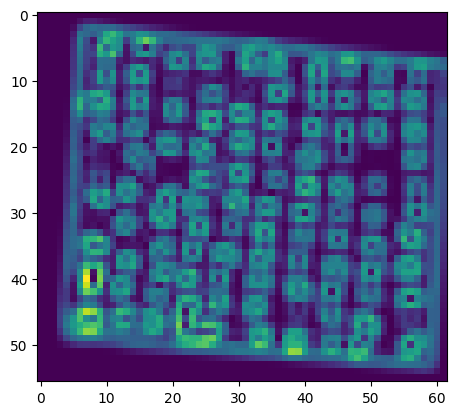

In [79]:
edge_smooth_data = smooth_edges(filtered_data)
plt.imshow(edge_smooth_data)

In [72]:
#Export to a new raster
meta.update(
    dtype=rasterio.float32,  # Update the data type to match the VARI data
    count=1,  # Only one band for VARI
    compress='lzw',  # You can choose a compression method if needed
    tiled=False,
    blockysize=1,
    nodata=0.0
)

In [57]:
# Create the new raster TIF file-1
with rasterio.open(output_raster, 'w', **meta) as dst:
    dst.write(edge_smooth_data, 1)

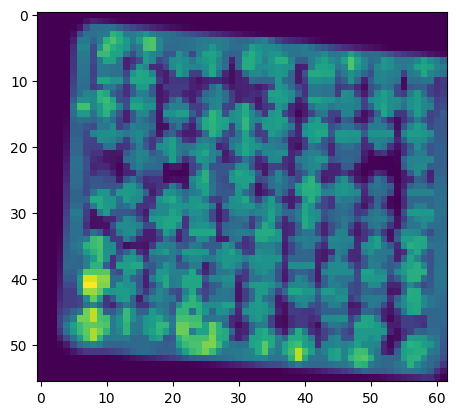

In [80]:
sdata = ndimage.gaussian_filter(edge_smooth_data, sigma=1)
sdata = ndimage.median_filter(edge_smooth_data, size=2)
plt.imshow(sdata)

In [81]:
#Export to a median
meta.update(
    dtype=rasterio.float32,  # Update the data type to match the VARI data
    count=1,  # Only one band for VARI
    compress='lzw',  # You can choose a compression method if needed
    tiled=False,
    blockysize=1,
    nodata=0.0
)
# Create the new raster TIF file-1
with rasterio.open(output_raster, 'w', **meta) as dst:
    dst.write(sdata, 1)